<a href="https://colab.research.google.com/github/FKz11/NLP/blob/main/lesson_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson-10

# Neural machine translation

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/

In [2]:
!wget http://www.manythings.org/anki/rus-eng.zip

--2022-09-22 16:38:33--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15011848 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.32M  5.89MB/s    in 2.4s    

2022-09-22 16:38:36 (5.89 MB/s) - ‘rus-eng.zip’ saved [15011848/15011848]



In [3]:
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [4]:
!ls /content/rus-eng/ -lah

total 72M
drwxr-xr-x 2 root root 4.0K Sep 22 16:38 .
drwxr-xr-x 1 root root 4.0K Sep 22 16:38 ..
-rw-r--r-- 1 root root 1.5K Sep  6 03:10 _about.txt
-rw-r--r-- 1 root root  72M Sep  6 03:10 rus.txt


In [5]:
# Download the file
path_to_file = "/content/rus-eng/rus.txt"

In [6]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [7]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [8]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, RUS]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [9]:
en, ru = create_dataset(path_to_file, None)
print(en[0])
print(ru[0])

<start> go . <end>
<start> марш ! <end>


In [10]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [11]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)


In [12]:
len(en), len(ru)

(451436, 451436)

In [13]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [14]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [15]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [16]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
10 ----> ты
299 ----> хорошая
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
28 ----> you're
92 ----> good
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [17]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [19]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=False,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_hidden = encoder(example_input_batch, sample_hidden)
# print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (64, 1024)


In [21]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

  def call(self, x, hidden):
    # enc_output shape == (batch_size, max_length, hidden_size)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state=hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state

In [22]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden)



In [23]:
decoder_sample_x.shape

TensorShape([64, 7335])

In [24]:
decoder_sample_h.shape

TensorShape([64, 1024])

## Define the optimizer and the loss function

In [25]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [26]:
checkpoint_dir = './training_nmt_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [27]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden = decoder(dec_input, dec_hidden)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [28]:
EPOCHS = 5

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.8042
Epoch 1 Batch 100 Loss 1.9654
Epoch 1 Batch 200 Loss 1.7689
Epoch 1 Batch 300 Loss 1.6321
Epoch 1 Batch 400 Loss 1.4608
Epoch 1 Batch 500 Loss 1.3060
Epoch 1 Batch 600 Loss 1.2987
Epoch 1 Batch 700 Loss 1.2999
Epoch 1 Batch 800 Loss 1.2044
Epoch 1 Batch 900 Loss 1.0311
Epoch 1 Batch 1000 Loss 0.9943
Epoch 1 Batch 1100 Loss 0.8988
Epoch 1 Batch 1200 Loss 0.9462
Epoch 1 Loss 1.3956
Time taken for 1 epoch 70.89350533485413 sec

Epoch 2 Batch 0 Loss 0.8698
Epoch 2 Batch 100 Loss 0.8122
Epoch 2 Batch 200 Loss 0.8385
Epoch 2 Batch 300 Loss 0.8135
Epoch 2 Batch 400 Loss 0.6829
Epoch 2 Batch 500 Loss 0.7531
Epoch 2 Batch 600 Loss 0.7334
Epoch 2 Batch 700 Loss 0.7128
Epoch 2 Batch 800 Loss 0.6412
Epoch 2 Batch 900 Loss 0.5582
Epoch 2 Batch 1000 Loss 0.6456
Epoch 2 Batch 1100 Loss 0.5755
Epoch 2 Batch 1200 Loss 0.5689
Epoch 2 Loss 0.7019
Time taken for 1 epoch 59.35044240951538 sec

Epoch 3 Batch 0 Loss 0.4724
Epoch 3 Batch 100 Loss 0.3834
Epoch 3 Batch 200 Loss 0.436

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [29]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input, dec_hidden)

    # storing the attention weights to plot later on
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [30]:
def translate(sentence):
  result, sentence = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  return result

## Restore the latest checkpoint and test

In [31]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Test

In [32]:
test = [('Yesterday we were in the park.', 'Вчера мы были в парке.'),
('Our team won.', 'Наша команда выиграла.'),
('I bought а new computer.', 'Я купил новый компьютер.'),
('Yesterday we played football.', 'Вчера мы играли в футбол.'),
('Nobody saw animals.', 'Никто не видел животных.'),
('The children sang songs.', 'Дети пели песню.'),
('The angry dog bit a small girl in the street.', 'Злая собака укусила девочку на улице.'),
('Who went to the cinema  yesterday?', 'Кто ходил вчера в кино?'),
("He came to school at 8 o'clock.", 'Он пришёл в школу в 8 часов.'),
('Spring is the season succeeding Winter and preceding Summer.', 'Весна - это сезон, следующий за Зимой и перед летом.'),
('I have to go to the university now but I will come back soon.', 'Я должен пойти сейчас в университет, но я скоро вернусь.'),
("Yesterday at school somebody stole the money from my friend's bag.", 'Вчера в школе кто-то украл деньги из сумки моей подруги.')]

In [33]:
nmt_pred = []
for i in test:
  nmt_pred.append(translate(i[1]))
  print('True translation: {}'.format(i[0]))
  print()

Input: <start> вчера мы были в парке . <end>
Predicted translation: we were all first . <end> 
True translation: Yesterday we were in the park.

Input: <start> наша команда выиграла . <end>
Predicted translation: our team won to win . <end> 
True translation: Our team won.

Input: <start> я купил новый компьютер . <end>
Predicted translation: i bought a new hat . <end> 
True translation: I bought а new computer.

Input: <start> вчера мы играли в футбол . <end>
Predicted translation: we were playing then . <end> 
True translation: Yesterday we played football.

Input: <start> никто не видел животных . <end>
Predicted translation: no one saw a ghost . <end> 
True translation: Nobody saw animals.

Input: <start> дети пели песню . <end>
Predicted translation: children need french . <end> 
True translation: The children sang songs.

Input: <start> злая собака укусила девочку на улице . <end>
Predicted translation: dad coat a dog . <end> 
True translation: The angry dog bit a small girl in t

Видно, что короткие предложения переводятся гораздо лучше, некоторые прям очень хорошо(наша команда выиграла - our team won to win), некоторые похуже(никто не видел животных - no one saw a ghost). А вот если предложение досаточно длинное, то перевод становится заметно хуже, он вообще неправильно переводит, при этом ставя знак <end> раньше времени(вчера в школе кто то украл деньги из сумки моей подруги - mary had one job)

# Neural machine translation with attention

In [34]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/

In [35]:
!wget http://www.manythings.org/anki/rus-eng.zip

--2022-09-22 16:44:18--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15011848 (14M) [application/zip]
Saving to: ‘rus-eng.zip.1’

rus-eng.zip.1       100%[===================>]  14.32M  5.90MB/s    in 2.4s    

2022-09-22 16:44:21 (5.90 MB/s) - ‘rus-eng.zip.1’ saved [15011848/15011848]



In [36]:
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

mkdir: cannot create directory ‘rus-eng’: File exists
Archive:  rus-eng.zip
replace rus-eng/rus.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [37]:
!ls /content/rus-eng/ -lah

total 72M
drwxr-xr-x 2 root root 4.0K Sep 22 16:38 .
drwxr-xr-x 1 root root 4.0K Sep 22 16:44 ..
-rw-r--r-- 1 root root 1.5K Sep  6 03:10 _about.txt
-rw-r--r-- 1 root root  72M Sep  6 03:10 rus.txt


In [38]:
# Download the file
path_to_file = "/content/rus-eng/rus.txt"

In [39]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [40]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [41]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, RUS]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [42]:
en, ru = create_dataset(path_to_file, None)
print(en[-1])
print(ru[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на земле людей , ни один подходящи

In [43]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [44]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)


In [45]:
len(en), len(ru)

(451436, 451436)

In [46]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [47]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [48]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [49]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
1747 ----> признаю
377 ----> сво
3357 ----> поражение
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
1110 ----> admit
18 ----> that
4 ----> i
143 ----> lost
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [50]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [51]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [52]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [53]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [54]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [55]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [56]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [57]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7335)


## Define the optimizer and the loss function

In [58]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [59]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [60]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [61]:
EPOCHS = 5

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5515
Epoch 1 Batch 100 Loss 2.1888
Epoch 1 Batch 200 Loss 1.8669
Epoch 1 Batch 300 Loss 1.7007
Epoch 1 Batch 400 Loss 1.6334
Epoch 1 Batch 500 Loss 1.4672
Epoch 1 Batch 600 Loss 1.4020
Epoch 1 Batch 700 Loss 1.2030
Epoch 1 Batch 800 Loss 1.2627
Epoch 1 Batch 900 Loss 1.2123
Epoch 1 Batch 1000 Loss 1.1439
Epoch 1 Batch 1100 Loss 1.1228
Epoch 1 Batch 1200 Loss 0.8448
Epoch 1 Loss 1.4802
Time taken for 1 epoch 112.82421731948853 sec

Epoch 2 Batch 0 Loss 0.8888
Epoch 2 Batch 100 Loss 0.8737
Epoch 2 Batch 200 Loss 0.7736
Epoch 2 Batch 300 Loss 0.7689
Epoch 2 Batch 400 Loss 0.6510
Epoch 2 Batch 500 Loss 0.7922
Epoch 2 Batch 600 Loss 0.6750
Epoch 2 Batch 700 Loss 0.5074
Epoch 2 Batch 800 Loss 0.5905
Epoch 2 Batch 900 Loss 0.4826
Epoch 2 Batch 1000 Loss 0.6972
Epoch 2 Batch 1100 Loss 0.4928
Epoch 2 Batch 1200 Loss 0.4731
Epoch 2 Loss 0.6503
Time taken for 1 epoch 101.76433277130127 sec

Epoch 3 Batch 0 Loss 0.3656
Epoch 3 Batch 100 Loss 0.4604
Epoch 3 Batch 200 Loss 0.3

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [62]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [63]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [69]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

  return result

## Restore the latest checkpoint and test

In [70]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Test

Input: <start> вчера мы были в парке . <end>
Predicted translation: we were in the park . <end> 


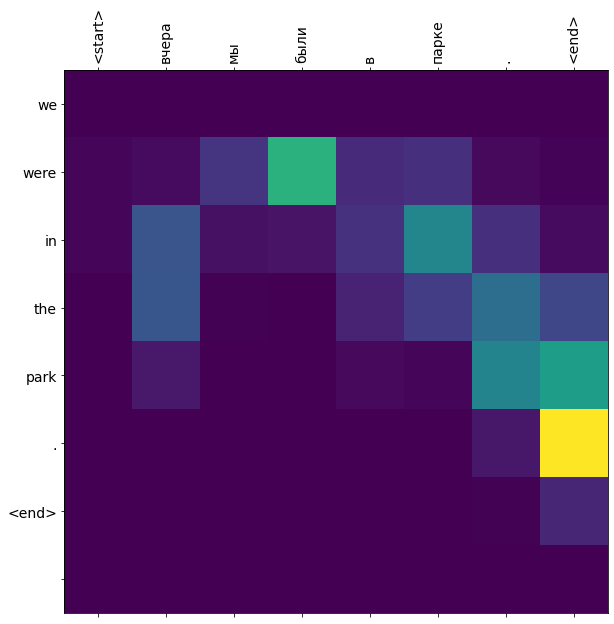

True translation: Yesterday we were in the park.

Input: <start> наша команда выиграла . <end>
Predicted translation: our team won . <end> 


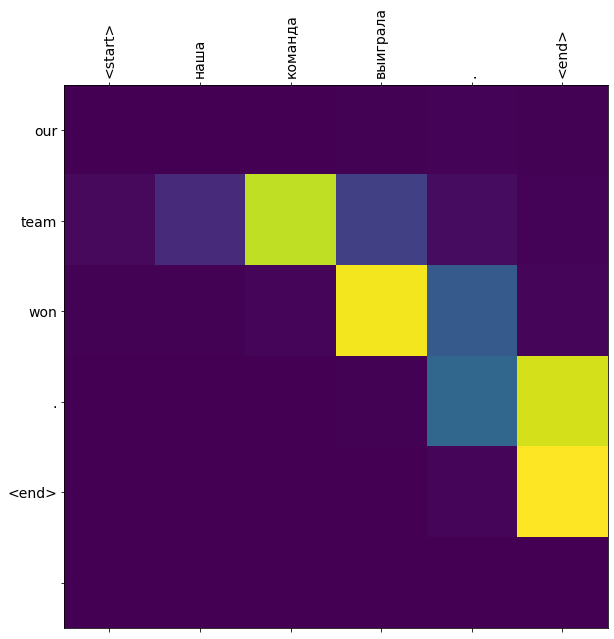

True translation: Our team won.

Input: <start> я купил новый компьютер . <end>
Predicted translation: i bought a new computer . <end> 


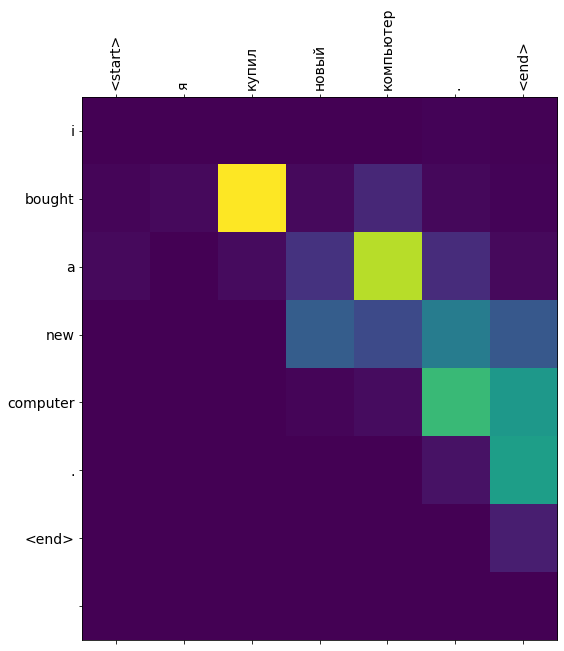

True translation: I bought а new computer.

Input: <start> вчера мы играли в футбол . <end>
Predicted translation: we played soccer soccer . <end> 


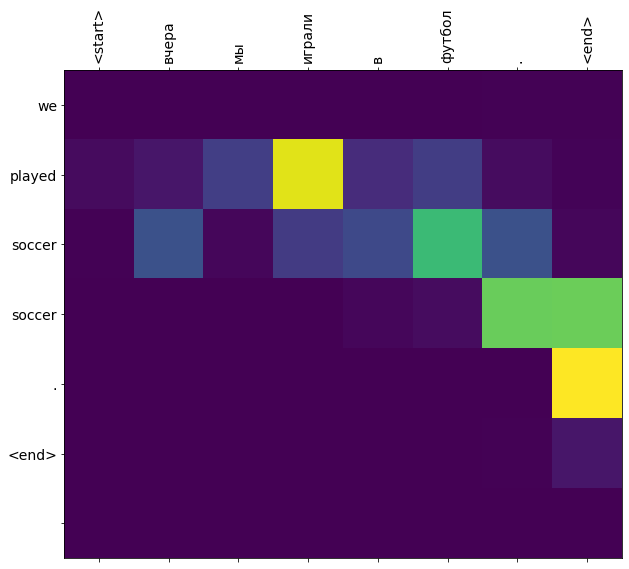

True translation: Yesterday we played football.

Input: <start> никто не видел животных . <end>
Predicted translation: nobody saw anything . <end> 


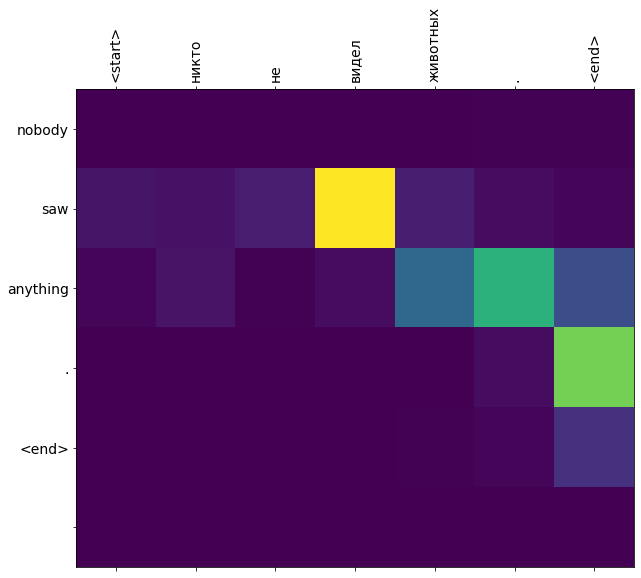

True translation: Nobody saw animals.

Input: <start> дети пели песню . <end>
Predicted translation: kids like english . <end> 


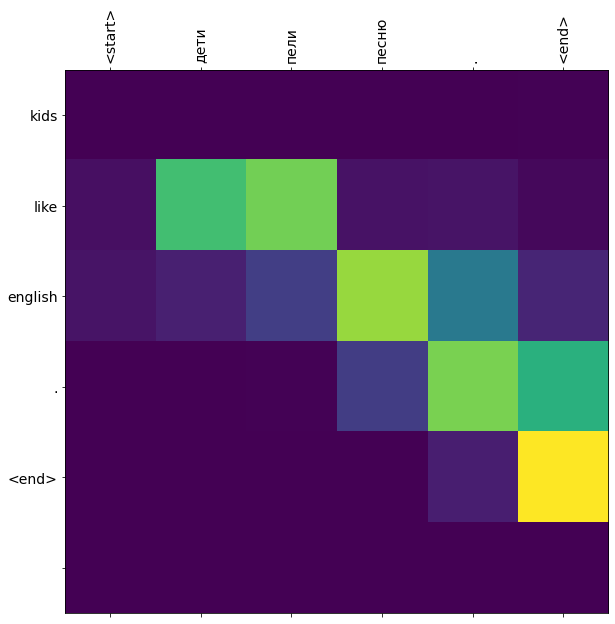

True translation: The children sang songs.

Input: <start> злая собака укусила девочку на улице . <end>
Predicted translation: what hit to be train . <end> 


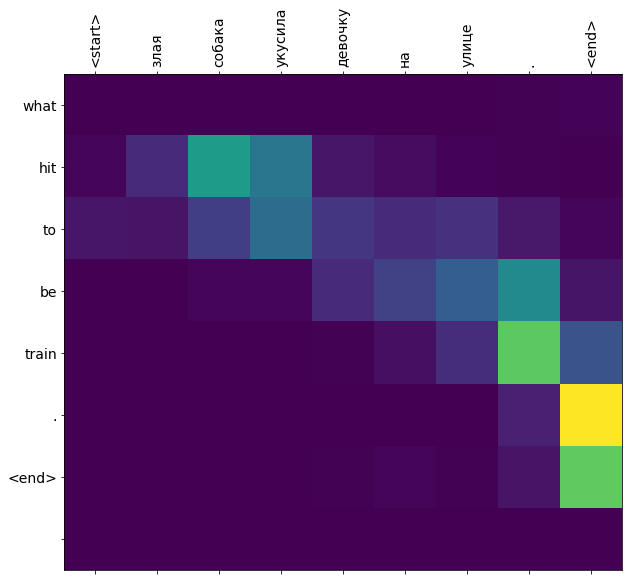

True translation: The angry dog bit a small girl in the street.

Input: <start> кто ходил вчера в кино ? <end>
Predicted translation: who went yesterday ? <end> 


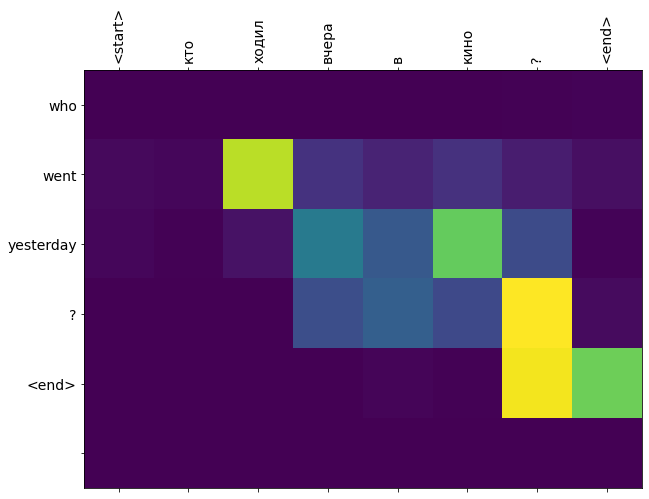

True translation: Who went to the cinema  yesterday?

Input: <start> он приш л в школу в часов . <end>
Predicted translation: he came to school . <end> 


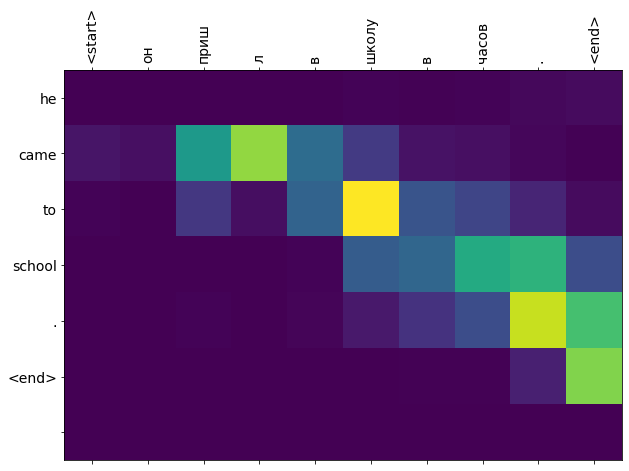

True translation: He came to school at 8 o'clock.

Input: <start> весна это сезон , следующий за зимой и перед летом . <end>
Predicted translation: he is where he is coming . <end> 


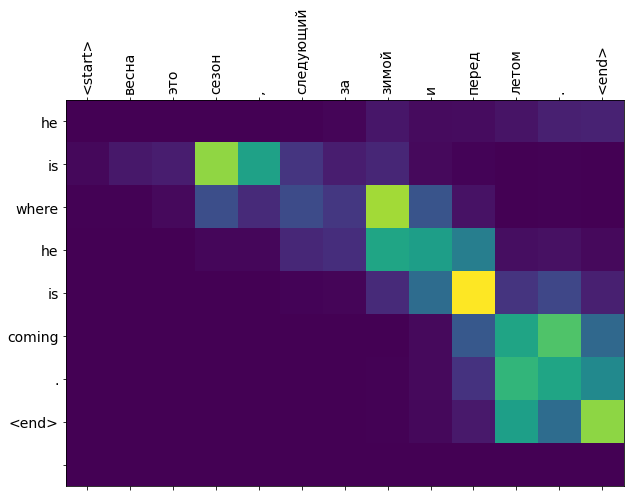

True translation: Spring is the season succeeding Winter and preceding Summer.

Input: <start> я должен пойти сейчас в университет , но я скоро вернусь . <end>
Predicted translation: i'm home now . <end> 


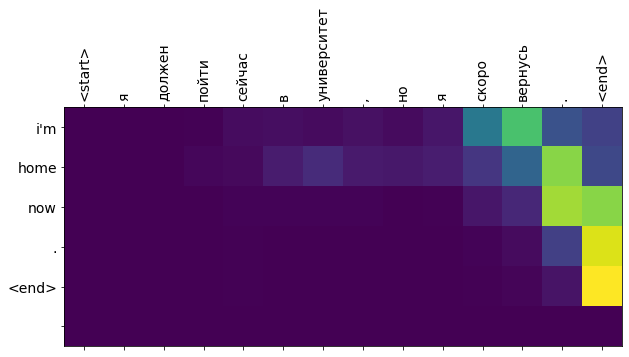

True translation: I have to go to the university now but I will come back soon.

Input: <start> вчера в школе кто то украл деньги из сумки моей подруги . <end>
Predicted translation: we all of french . <end> 


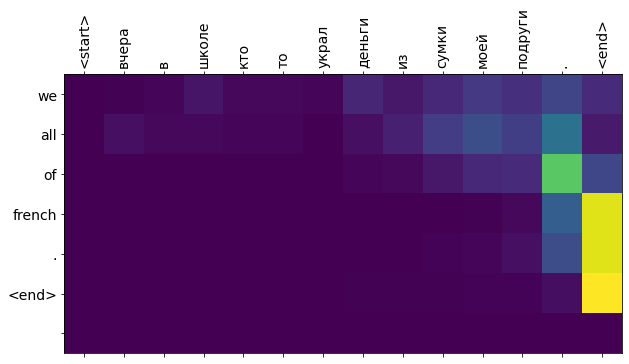

True translation: Yesterday at school somebody stole the money from my friend's bag.



In [71]:
nmt_with_attention_pred = []
for i in test:
  nmt_with_attention_pred.append(translate(i[1]))
  print('True translation: {}'.format(i[0]))
  print()

Видно, что у модели так же не получается переводить сложные и длинные предложения.

По attention_plot можно увидеть, что когда слой внимания показывает правильное слово из входного предложения при генерации нового слова, то и перевод становится отличным. Это можно увидеть на первых 5 примерах, где слой внимания правильно сопостовляет ключевые сущиствительные или глаголы. А где слой внимания не правильно сопостовляет токены и зацикливается на токене конца <end>, например в последних 2-ух примерах после первых 2-ух токенов. То и перевод получается совсем непрвильным.

# Сравним:

In [73]:
for i in range(len(test)):
  print('nmt: '+nmt_pred[i])
  print('nmt_with_attention: '+nmt_with_attention_pred[i])
  print('True: '+test[i][0])
  print('Ru: '+test[i][1])
  print()

nmt: we were all first . <end> 
nmt_with_attention: we were in the park . <end> 
True: Yesterday we were in the park.
Ru: Вчера мы были в парке.

nmt: our team won to win . <end> 
nmt_with_attention: our team won . <end> 
True: Our team won.
Ru: Наша команда выиграла.

nmt: i bought a new hat . <end> 
nmt_with_attention: i bought a new computer . <end> 
True: I bought а new computer.
Ru: Я купил новый компьютер.

nmt: we were playing then . <end> 
nmt_with_attention: we played soccer soccer . <end> 
True: Yesterday we played football.
Ru: Вчера мы играли в футбол.

nmt: no one saw a ghost . <end> 
nmt_with_attention: nobody saw anything . <end> 
True: Nobody saw animals.
Ru: Никто не видел животных.

nmt: children need french . <end> 
nmt_with_attention: kids like english . <end> 
True: The children sang songs.
Ru: Дети пели песню.

nmt: dad coat a dog . <end> 
nmt_with_attention: what hit to be train . <end> 
True: The angry dog bit a small girl in the street.
Ru: Злая собака укусила 

Посмотрев на первые 4 примера, где модель справилась почти идеально, можно сказать, что модель со слоем внимания внимания оказалось заметно лучше, чем модель без этого слоя. Хотя и последние примеры ей так же не удались.

# Вывод:

Я разобрался как устроен слой внимания и протестировал его в задаче перевода.

Я сравнил перевод текста в зависимости от наличия слоя внимания в индетичных моделях, на одних и тех же данных, и убедился что слой внимания сильно помогает при переводе.

Стоит отметить, что модель со слоем внимания обучается в 1.5 раза дольше. При этом loss на train у модели со слоем внимания оказался чуть меньше. А мы его можем сравнивать, потому что loss и данные были одинаковыми.

Видимо последние предложения слишком сложные, поэтому даже слой внимания не смог помочь.

Но на самом деле 5 эпох конечно очень мало, особенно для модели со слоем внимания, если обучать модель по дольше, то может результаты будут лучше.